In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
import matplotlib.pyplot as plt
import datetime

# check available GPU

In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

# encoder

In [25]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, padding='same',
                                  kernel_size=(kernel_size, kernel_size))(x)
        x = tf.keras.layers.Activation('relu')(x)
        
    return x

In [26]:
def encoder_block(inputs, n_filters, pool_size, dropout):
    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    
    return f, p

In [36]:
def encoder(inputs):
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)
    
    return p4, (f1, f2, f3, f4)

In [28]:
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    
    return bottle_neck

# decoder block

In [33]:
def decoder_block(inputs, conv_output, n_filters, kernel_size, strides, dropout):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides,
                                      padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)
    
    return c

In [30]:
def decoder(inputs, convs):
    f1, f2, f3, f4 = convs
    
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    
    outputs = tf.keras.layers.Conv2D(3, (1,1), activation='softmax')(c9)
    
    return outputs

In [34]:
def unet():
    inputs = tf.keras.layers.Input(shape=(128,128,3))
    encoder_output, convs = encoder(inputs)
    
    bottle_neck = bottleneck(encoder_output)
    
    outputs = decoder(bottle_neck, convs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [35]:
model = unet()
model.summary()

Tensor("dropout_24/Identity:0", shape=(None, 64, 64, 64), dtype=float32)
1
1
(None, 8, 8, 512)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 128, 128, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 128, 128, 64) 0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 128, 128, 64) 36928       activation_55[0][0]              

# GPU setup

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# visualization

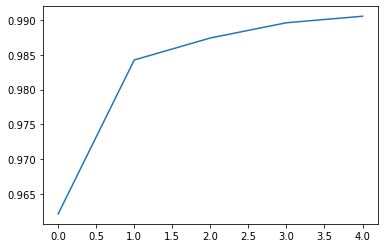

In [12]:
plt.plot(history.history['acc'])